К текущему моменту мы научились обучать простейшую линейную регрессию: причем научились пользоваться как готовыми методами из sklearn, так и реализовывать поиск решения оптимальных коэффициентов самостоятельно с помощью градиентного спуска.

На последних занятиях мы узнали, что на практике часто приходится прибегать к некоторым хитростям, чтобы оценить, действительно ли модель отлично справляется со своей главной задачей - делать хорошие предсказания на новых данных в будущем, или, как еще говорят, в проде - после запуска.

Для этого было введено понятие так называемой обобщающей способности модели. Оно помогает нам оценить, насколько наша модель подогналась под увиденные данные и насколько она окажется хороша на новых данных.

Обобщающую способность мы научились оценивать с помощью метода Кросс-Валидации.



Построим для старой задачи с предсказанием длительности поездки в такси 2 модели линейной регрессии. Для каждой из них замерим качество на кросс-валидации и на тесте, заранее его отложив.

Считается, что если для K-Fold Кросс-Валидации брать большие значения K (то есть большое количество сплитов для разбиения тренировочной выборки на тренировку-валидацию), то оценка среднеквадратической ошибки будет получаться более справедливой. Так, например, когда K оказывается максимальным, а именно равным количеству объектов в выборке (каждый раз в валидации у нас 1 новый объект), то такой метод Кросс-Валидации еще называют LeaveOneOut.

Главная причина, почему мало где его используют, состоит в дороговизне такого метода. Например, в данной задаче в TAXI_train.csv лежит почти 1,2 млн. объектов. Тогда, чтобы замерить качество на LeaveOneOut валидации, нам пришлось бы обучить 1,2 млн. различных версий одной модели, что, конечно, не вписыватеся в рамки адекватного времени и прочих ресурсов.

Поэтому выберем компромиссное значение в виде 20 фолдов для K-Fold Кросс-Валидации.

Внимание! Для каждой из 2 моделей очевидно было бы справедливым замерять качество на тех же самых объектах, поэтому сплиты лучше зафиксировать сразу.

P.S. Оптимизировать будем MSLE метрику. И сравнивать модели тоже будем по ней будем. Как из домашнего задания про метрики, только без корня! :)

$$\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$


### Модель №1 Для начала посчитаем ошибку на Кросс-Валидации и Тесте для нашей самой базовой модели до вычленения каких-либо признаков, а просто взяв все вещественные колонки.

In [156]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use ('dark_background')

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 12
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 12
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['axes.titlesize'] = 16
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [157]:
file_path = '../data/initial_data.csv'
initial_data = pd.read_csv(file_path, index_col='id')

initial_cols = ['vendor_id', 'passenger_count', 'pickup_longitude',
                'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'trip_duration']

initial_data = initial_data[initial_cols]
initial_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
id,,,,,,,
id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455.0
id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663.0
id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0
id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,429.0
id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,435.0
...,...,...,...,...,...,...,...
id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,778.0
id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,655.0
id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,764.0


### ТрюК!

In [158]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

initial_data = initial_data.assign(log_trip_duration=np.log1p(initial_data['trip_duration']))
initial_data = initial_data.drop('trip_duration', axis=1)
initial_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration
id,,,,,,,
id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,6.122493
id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,6.498282
id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,7.661527
id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,6.063785
id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,6.077642
...,...,...,...,...,...,...,...
id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,6.658011
id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,6.486161
id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,6.639876


### Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:
$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:
$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

А это в точности MSLE от $y$:

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

In [159]:
### Выделим test

from sklearn.model_selection import train_test_split

X = initial_data.drop('log_trip_duration', axis=1)
y = initial_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [160]:
### Применим K-Fold на оставшуюяся валидационную часть X_train, y_train

from sklearn.model_selection import KFold

splitter = KFold(n_splits=20, shuffle=True, random_state=33)

In [161]:
### Замерьте качество на кросс-валидации!
### Your code is here

from sklearn.linear_model import LinearRegression

splitter.split(X)

losses_train = []
losses_test = []

for train_index, test_index in splitter.split(X):
    X_train_i, X_test_i = X.values[train_index], X.values[test_index]
    y_train_i, y_test_i = y.values[train_index], y.values[test_index]

    model_cross_val = LinearRegression()
    model_cross_val.fit(X_train_i, y_train_i)

    losses_train.append(np.mean((model_cross_val.predict(X_train_i)-y_train_i)**2))
    losses_test.append(np.mean((model_cross_val.predict(X_test_i)-y_test_i)**2))


In [162]:
print(f"Train Val Mean: {round(np.mean(losses_train), 3)}")
print(f"Test Val Mean: {round(np.mean(losses_test), 3)}")

Train Val Mean: 0.608
Test Val Mean: 0.613


In [163]:
### Теперь построим модель на всей тренировочной выборке
### и замерим качество на тесте!
### Your code is here

model_control = LinearRegression()
model_control.fit(X_train, y_train)

MSE_train_control = np.mean((model_control.predict(X_train)-y_train)**2)
MSE_test_control = np.mean((model_control.predict(X_test)-y_test)**2)

print(f"Train Control: {round(MSE_train_control, 3)}")
print(f"Test Control: {round(MSE_test_control, 3)}")


Train Control: 0.609
Test Control: 0.606


In [164]:
df_train = y_train.to_frame()
df_train.reset_index(drop=True, inplace=True)
df_train.rename(columns={'log_trip_duration': 'ground_truth'}, inplace=True)
df_test = y_test.to_frame()
df_test.reset_index(drop=True, inplace=True)
df_test.rename(columns={'log_trip_duration': 'ground_truth'}, inplace=True)

train_prediction = pd.DataFrame(model_control.predict(X_train), columns=['prediction'])
train_prediction.reset_index(drop=True, inplace=True)
train_prediction = pd.concat([train_prediction, df_train], axis=1)

train_prediction_GT = train_prediction['ground_truth'].sort_values()
train_prediction_GT.reset_index(drop=True, inplace=True)

test_prediction = pd.DataFrame(model_control.predict(X_test), columns=['prediction'])
test_prediction.reset_index(drop=True, inplace=True)
test_prediction = pd.concat([test_prediction, df_test], axis=1)

test_prediction_GT = test_prediction['ground_truth'].sort_values()
test_prediction_GT.reset_index(drop=True, inplace=True)

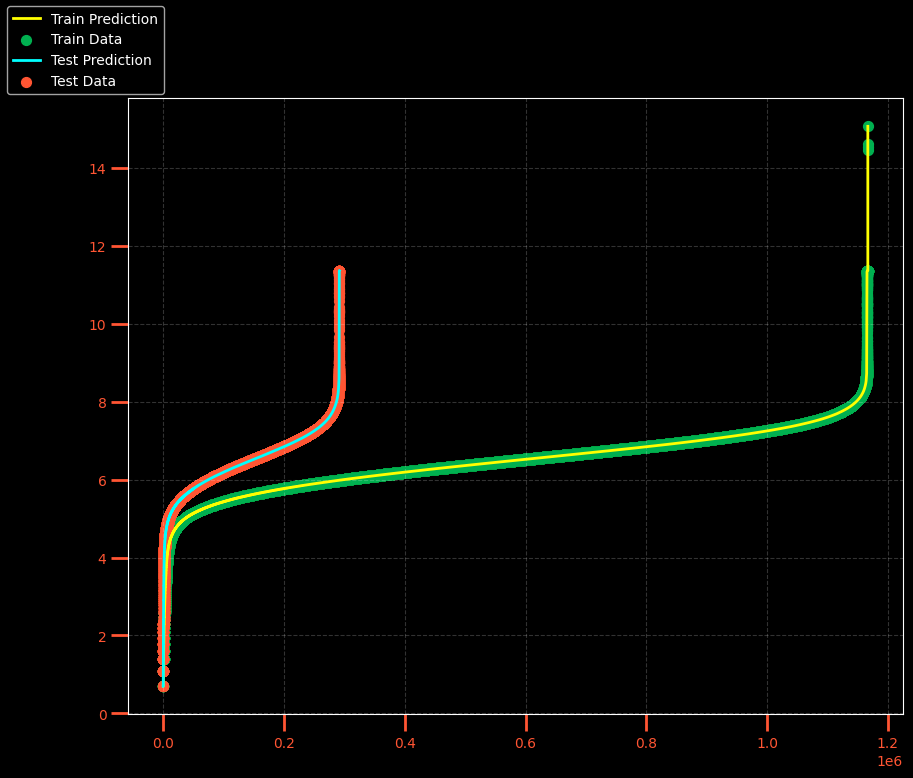

In [165]:
fig = plt.figure()
fig.set_size_inches(10, 8)

plt.plot(train_prediction_GT, color='yellow')
plt.scatter(df_train.index, df_train['ground_truth'].sort_values().reset_index(drop=True), c='#00B050', s=50)

plt.plot(test_prediction_GT, color='cyan')
plt.scatter(df_test.index, df_test['ground_truth'].sort_values().reset_index(drop=True), c='#FF5533', s=50)

# Передача меток как одного списка
fig.legend(['Train Prediction', 'Train Data', 'Test Prediction', 'Test Data'], loc='upper left')

plt.grid(True, alpha=0.2, linestyle='--', color='white')
plt.show()


In [166]:
### Укажите в ответе на задание 4 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Модель №2. Проделаем все то же самое, только для модели с более осознанными признаками, которые удалось получить ранее

In [167]:
file_path = '../data/processed_data.csv'
processed_data = pd.read_csv(file_path, index_col='id')

In [168]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,
id2875421,1,930.399753,0,455.0,1.500479
id2377394,0,930.399753,0,663.0,1.807119
id3858529,1,930.399753,0,2124.0,6.392080
id3504673,1,930.399753,0,429.0,1.487155
id2181028,1,930.399753,0,435.0,1.189925


In [169]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

processed_data = processed_data.assign(log_trip_duration=np.log1p(processed_data['trip_duration']))
processed_data = processed_data.drop('trip_duration', axis=1)

In [170]:
X_2 = processed_data.drop('log_trip_duration', axis=1)
y_2 = processed_data['log_trip_duration']

In [171]:
### Важно! Когда сравниваем модели по их качеству
### на валидации и на тесте, не шаффлим данные заново!

# Определение индексов для обучающего и тестового наборов данных

# Определение индексов для обучающего и тестового наборов данных
test_indexes = X_test.index
train_indexes = X_train.index

# Создание X_train_2, y_train_2, X_test_2, y_test_2 с использованием индексов
X_train_2 = X_2.loc[train_indexes]
y_train_2 = y_2.loc[train_indexes]
X_test_2 = X_2.loc[test_indexes]
y_test_2 = y_2.loc[test_indexes]

In [172]:
### Замерьте качество на кросс-валидации!
### Your code is here

# Инициализация KFold splitter с теми же параметрами
splitter = KFold(n_splits=20, shuffle=True, random_state=33)

# Инициализация списков для хранения MSE на обучении и тесте для каждого фолда
losses_train_cv = []
losses_test_cv = []

# Цикл по фолдам
for train_index, test_index in splitter.split(X_train_2):
    X_train_i, X_test_i = X_train_2.values[train_index], X_train_2.values[test_index]
    y_train_i, y_test_i = y_train_2.values[train_index], y_train_2.values[test_index]

    # Обучение модели на обучающем наборе текущего фолда
    model_cv = LinearRegression()
    model_cv.fit(X_train_i, y_train_i)

    # Оценка модели на обучающем и тестовом наборе текущего фолда
    losses_train_cv.append(np.mean((model_cv.predict(X_train_i)-y_train_i)**2))
    losses_test_cv.append(np.mean((model_cv.predict(X_test_i)-y_test_i)**2))

# Вывод результатов
print(f"Cross-Validation Train MSE Mean: {round(np.mean(losses_train_cv), 3)}")
print(f"Cross-Validation Test MSE Mean: {round(np.mean(losses_test_cv), 3)}")

Cross-Validation Train MSE Mean: 0.429
Cross-Validation Test MSE Mean: 0.431


In [173]:
### Теперь построим модель и замерим качество на тесте!
### Your code is here

model_control_2 = LinearRegression()
model_control_2.fit(X_train_2, y_train_2)

MSE_train_control_2 = np.mean((model_control_2.predict(X_train_2)-y_train_2)**2)
MSE_test_control_2 = np.mean((model_control_2.predict(X_test_2)-y_test_2)**2)

print(f"Train Control: {round(MSE_train_control_2, 3)}")
print(f"Test Control: {round(MSE_test_control_2, 3)}")



Train Control: 0.429
Test Control: 0.407


In [174]:
### Укажите в ответе на задание 5 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Какую модель среди двух стоило бы выбрать? Помогла ли нам базовая обработка признаков с первых уроков? 